### Import modules and packages

In [1]:
import logging
import os
from typing import Sequence

import fire
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
from torch import nn
from torch import optim
from torch.distributions import Normal

import torchsde
import matplotlib.cm as cm

## Linear scheduler

In [2]:
class LinearScheduler(object):
    def __init__(self, iters, maxval=1.0):
        self._iters = max(1, iters)
        self._val = maxval / self._iters
        self._maxval = maxval

    def step(self):
        self._val = min(self._maxval, self._val + self._maxval / self._iters)

    @property
    def val(self):
        return self._val

## Stochastic Lorenz attractor system -- real data

In [3]:
class StochasticLorenz(object):
    """Stochastic Lorenz attractor.

    Used for simulating ground truth and obtaining noisy data.
    Details described in Section 7.2 https://arxiv.org/pdf/2001.01328.pdf
    Default a, b from https://openreview.net/pdf?id=HkzRQhR9YX
    """
    noise_type = "diagonal"
    sde_type = "ito"

    # b: Sequence = (.1, .28, .3)
    def __init__(self, a: Sequence = (10., 28., 8 / 3), b: Sequence = (.1, .28, .3)):
        super(StochasticLorenz, self).__init__()
        self.a = a
        self.b = b

    def f(self, t, y):
        x1, x2, x3 = torch.split(y, split_size_or_sections=(1, 1, 1), dim=1)
        a1, a2, a3 = self.a

        f1 = a1 * (x2 - x1)
        f2 = a2 * x1 - x2 - x1 * x3
        f3 = x1 * x2 - a3 * x3
        return torch.cat([f1, f2, f3], dim=1)

    def g(self, t, y):
        x1, x2, x3 = torch.split(y, split_size_or_sections=(1, 1, 1), dim=1)
        b1, b2, b3 = self.b

        g1 = x1 * b1
        g2 = x2 * b2
        g3 = x3 * b3
        return torch.cat([g1, g2, g3], dim=1)

    @torch.no_grad()
    def sample(self, x0, ts, noise_std, normalize):
        """Sample data for training. Store data normalization constants if necessary."""
        xs = torchsde.sdeint(self, x0, ts)
        if normalize:
            mean, std = torch.mean(xs, dim=(0, 1)), torch.std(xs, dim=(0, 1))
            xs.sub_(mean).div_(std).add_(torch.randn_like(xs) * noise_std)
        return xs

## Get dataset

In [17]:
def make_dataset(t0, t1, batch_size, noise_std, train_dir, device):
    data_path = os.path.join(train_dir, 'lorenz_data.pth')
    if os.path.exists(data_path):
        data_dict = torch.load(data_path)
        xs, ts = data_dict['xs'], data_dict['ts']
        logging.warning(f'Loaded toy data at: {data_path}')
        if xs.shape[1] != batch_size:
            raise ValueError("Batch size has changed; please delete and regenerate the data.")
        if ts[0] != t0 or ts[-1] != t1:
            raise ValueError("Times interval [t0, t1] has changed; please delete and regenerate the data.")
    else:
        _y0 = torch.randn(batch_size, 3, device=device)
        ts = torch.linspace(t0, t1, steps=100, device=device)
        xs = StochasticLorenz().sample(_y0, ts, noise_std, normalize=True)

        os.makedirs(os.path.dirname(data_path), exist_ok=True)
        torch.save({'xs': xs, 'ts': ts}, data_path)
        logging.warning(f'Stored toy data at: {data_path}')
    return xs, ts


## Encoder

In [18]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Encoder, self).__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size)
        self.lin = nn.Linear(hidden_size, output_size)

    def forward(self, inp):
        out, _ = self.gru(inp)
        out = self.lin(out)
        return out

## Latent SDE model

In [19]:
class LatentSDE(nn.Module):
    sde_type = "ito"
    noise_type = "diagonal"

    def __init__(self, data_size, latent_size, context_size, hidden_size):
        super(LatentSDE, self).__init__()
        # Encoder.
        self.encoder = Encoder(input_size=data_size, hidden_size=hidden_size, output_size=context_size)
        self.qz0_net = nn.Linear(context_size, latent_size + latent_size)

        # Decoder.
        self.f_net = nn.Sequential(
            nn.Linear(latent_size + context_size, hidden_size),
            nn.Softplus(),
            nn.Linear(hidden_size, hidden_size),
            nn.Softplus(),
            nn.Linear(hidden_size, latent_size),
        )
        self.h_net = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.Softplus(),
            nn.Linear(hidden_size, hidden_size),
            nn.Softplus(),
            nn.Linear(hidden_size, latent_size),
        )
        # This needs to be an element-wise function for the SDE to satisfy diagonal noise.
        self.g_nets = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(1, hidden_size),
                    nn.Softplus(),
                    nn.Linear(hidden_size, 1),
                    nn.Sigmoid()
                )
                for _ in range(latent_size)
            ]
        )
        self.projector = nn.Linear(latent_size, data_size)

        self.pz0_mean = nn.Parameter(torch.zeros(1, latent_size))
        self.pz0_logstd = nn.Parameter(torch.zeros(1, latent_size))

        self._ctx = None

    def contextualize(self, ctx):
        self._ctx = ctx  # A tuple of tensors of sizes (T,), (T, batch_size, d).

    def f(self, t, y):
        ts, ctx = self._ctx
        i = min(torch.searchsorted(ts, t, right=True), len(ts) - 1)
        return self.f_net(torch.cat((y, ctx[i]), dim=1))

    def h(self, t, y):
        return self.h_net(y)

    def g(self, t, y):  # Diagonal diffusion.
        y = torch.split(y, split_size_or_sections=1, dim=1)
        out = [g_net_i(y_i) for (g_net_i, y_i) in zip(self.g_nets, y)]
        return torch.cat(out, dim=1)

    def forward(self, xs, ts, noise_std, adjoint=False, method="euler"):
        # Contextualization is only needed for posterior inference.
        ctx = self.encoder(torch.flip(xs, dims=(0,)))
        ctx = torch.flip(ctx, dims=(0,))
        self.contextualize((ts, ctx))

        qz0_mean, qz0_logstd = self.qz0_net(ctx[0]).chunk(chunks=2, dim=1)
        z0 = qz0_mean + qz0_logstd.exp() * torch.randn_like(qz0_mean)

        if adjoint:
            # Must use the argument `adjoint_params`, since `ctx` is not part of the input to `f`, `g`, and `h`.
            adjoint_params = (
                    (ctx,) +
                    tuple(self.f_net.parameters()) + tuple(self.g_nets.parameters()) + tuple(self.h_net.parameters())
            )
            zs, log_ratio = torchsde.sdeint_adjoint(
                self, z0, ts, adjoint_params=adjoint_params, dt=1e-2, logqp=True, method=method)
        else:
            zs, log_ratio = torchsde.sdeint(self, z0, ts, dt=1e-2, logqp=True, method=method)

        _xs = self.projector(zs)
        xs_dist = Normal(loc=_xs, scale=noise_std)
        log_pxs = xs_dist.log_prob(xs).sum(dim=(0, 2)).mean(dim=0)

        qz0 = torch.distributions.Normal(loc=qz0_mean, scale=qz0_logstd.exp())
        pz0 = torch.distributions.Normal(loc=self.pz0_mean, scale=self.pz0_logstd.exp())
        logqp0 = torch.distributions.kl_divergence(qz0, pz0).sum(dim=1).mean(dim=0)
        logqp_path = log_ratio.sum(dim=0).mean(dim=0)
        return log_pxs, logqp0 + logqp_path

    @torch.no_grad()
    def sample(self, batch_size, ts, bm=None):
        eps = torch.randn(size=(batch_size, *self.pz0_mean.shape[1:]), device=self.pz0_mean.device)
        z0 = self.pz0_mean + self.pz0_logstd.exp() * eps
        zs = torchsde.sdeint(self, z0, ts, names={'drift': 'h'}, dt=1e-3, bm=bm)
        # Most of the times in ML, we don't sample the observation noise for visualization purposes.
        _xs = self.projector(zs)
        return _xs

## Visualization

In [20]:
def vis(xs, ts, latent_sde, bm_vis, img_path, num_samples=10, method = "euler"):
    num_rows = 1 + num_samples
    fig = plt.figure(figsize=(20, 9 * num_rows))
    gs = gridspec.GridSpec(num_rows, 2, fig)

    # Left plot: data.
    ax00 = plt.subplot(gs[0, 0], projection='3d')
    z1, z2, z3 = np.split(xs.cpu().numpy(), indices_or_sections=3, axis=-1)
    [ax00.plot(z1[:, i, 0], z2[:, i, 0], z3[:, i, 0]) for i in range(num_samples)]
    ax00.scatter(z1[0, :num_samples, 0], z2[0, :num_samples, 0], z3[0, :num_samples, 0], marker='x')
    ax00.set_yticklabels([])
    ax00.set_xticklabels([])
    ax00.set_zticklabels([])
    ax00.set_xlabel('$z_1$', labelpad=0., fontsize=16)
    ax00.set_ylabel('$z_2$', labelpad=.5, fontsize=16)
    ax00.set_zlabel('$z_3$', labelpad=0., horizontalalignment='center', fontsize=16)
    ax00.set_title('Data', fontsize=20)
    xlim = ax00.get_xlim()
    ylim = ax00.get_ylim()
    zlim = ax00.get_zlim()

    # Right plot: samples from learned model.
    generated_xs = latent_sde.sample(batch_size=xs.size(1), ts=ts, bm=bm_vis).cpu().numpy()
    z1, z2, z3 = np.split(generated_xs, indices_or_sections=3, axis=-1)
    ax01 = plt.subplot(gs[0, 1], projection='3d')
    [ax01.plot(z1[:, i, 0], z2[:, i, 0], z3[:, i, 0]) for i in range(num_samples)]
    ax01.scatter(z1[0, :num_samples, 0], z2[0, :num_samples, 0], z3[0, :num_samples, 0], marker='x')
    ax01.set_yticklabels([])
    ax01.set_xticklabels([])
    ax01.set_zticklabels([])
    ax01.set_xlabel('$z_1$', labelpad=0., fontsize=16)
    ax01.set_ylabel('$z_2$', labelpad=.5, fontsize=16)
    ax01.set_zlabel('$z_3$', labelpad=0., horizontalalignment='center', fontsize=16)
    ax01.set_title('Samples', fontsize=20)
    ax01.set_xlim(xlim)
    ax01.set_ylim(ylim)
    ax01.set_zlim(zlim)

    # plot posterior samples
    

    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'indigo', 'lime', 'orange']


    for i in range(num_samples):
        row = i + 1
        color = colors[i % len(colors)]

        ax = plt.subplot(gs[row, 0], projection='3d')
        sample_xs = xs[:, i, :].cpu().numpy()
        z1, z2, z3 = np.split(sample_xs, indices_or_sections=3, axis=-1)
        ax.scatter(z1[:, 0], z2[:, 0], z3[:, 0], color=color, marker='x', s=40, label = f"Data {i+1}")

        ctx = latent_sde.encoder(torch.flip(xs, dims=(0,)))
        ctx = torch.flip(ctx, dims=(0,))
        latent_sde.contextualize((ts, ctx))
        qz0_mean, qz0_logstd = latent_sde.qz0_net(ctx[0]).chunk(chunks=2, dim=1)
        z0 = qz0_mean + qz0_logstd.exp() * torch.randn_like(qz0_mean)
        zs, log_ratio = torchsde.sdeint(latent_sde, z0, ts, dt=1e-2, logqp=True, method=method)
        _xs = latent_sde.projector(zs)

        post_xs = _xs[:, i, :].cpu().detach().numpy()
        p1, p2, p3 = np.split(post_xs, indices_or_sections=3, axis=-1)
        ax.plot(p1[:, 0], p2[:, 0], p3[:, 0], color=color, label = f"Posterior Sample {i+1}")

        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_zticklabels([])
        ax.set_xlabel('$z_1$', labelpad=0., fontsize=16)
        ax.set_ylabel('$z_2$', labelpad=.5, fontsize=16)
        ax.set_zlabel('$z_3$', labelpad=0., horizontalalignment='center', fontsize=16)
        ax.set_title(f'Sample Trajectory {i+1}', fontsize=20)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_zlim(zlim)      

    plt.savefig(img_path)
    plt.close()


## Main program for training

In [21]:
batch_size=1024
latent_size=4
context_size=64
hidden_size=128
lr_init=1e-2
t0=0.
t1=8.
lr_gamma=0.997
kl_anneal_iters=1000
pause_every=50
noise_std=0.01
adjoint=False
train_dir='./lorenzTestTime8/'
method="euler"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
xs, ts = make_dataset(t0=t0, t1=t1, batch_size=batch_size, noise_std=noise_std, 
                      train_dir=train_dir, device=device)

# xs.size() = [100, 1024, 3], 100 time steps, 1024 batch size, 3 dimensions
# ts.size() = [100], 100 time steps

In [10]:
# z1 = [1024 x values at t0], [1024 x values at t1], [1024 x values at t2], ...[1024 x values at t99]

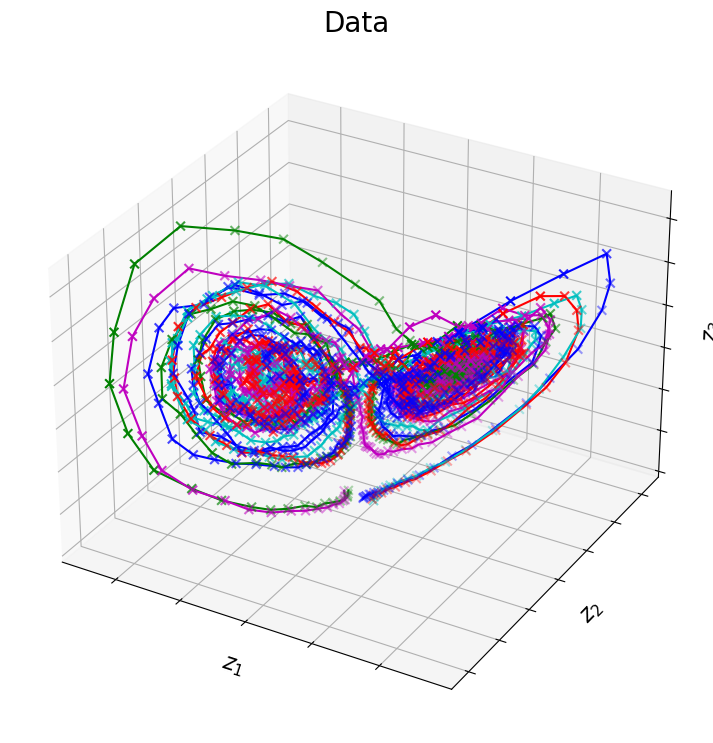

In [11]:
# plot training data in 3D
z1, z2, z3 = np.split(xs.cpu().numpy(), indices_or_sections=3, axis=-1)
# define a plot with 3d projection
fig = plt.figure(figsize=(20, 9))
ax = fig.add_subplot(111, projection='3d')
num_samples = 5
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

[ax.plot(z1[:, i, 0], z2[:, i, 0], z3[:, i, 0], color = colors[i % len(colors)]) for i in range(num_samples)]
[ax.scatter(z1[:, i, 0], z2[:, i, 0], z3[:, i, 0], marker = 'x', color = colors[i % len(colors)],s=40) 
 for i in range(num_samples)]
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_zticklabels([])
ax.set_xlabel('$z_1$', labelpad=0., fontsize=16)
ax.set_ylabel('$z_2$', labelpad=.5, fontsize=16)
ax.set_zlabel('$z_3$', labelpad=0., horizontalalignment='center', fontsize=16)
ax.set_title('Data', fontsize=20)
plt.show()

In [12]:
latent_sde = LatentSDE(
    data_size=3,
    latent_size=latent_size,
    context_size=context_size,
    hidden_size=hidden_size,
).to(device)

In [13]:
latent_sde

LatentSDE(
  (encoder): Encoder(
    (gru): GRU(3, 128)
    (lin): Linear(in_features=128, out_features=64, bias=True)
  )
  (qz0_net): Linear(in_features=64, out_features=8, bias=True)
  (f_net): Sequential(
    (0): Linear(in_features=68, out_features=128, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=128, out_features=4, bias=True)
  )
  (h_net): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=128, out_features=4, bias=True)
  )
  (g_nets): ModuleList(
    (0-3): 4 x Sequential(
      (0): Linear(in_features=1, out_features=128, bias=True)
      (1): Softplus(beta=1, threshold=20)
      (2): Linear(in_features=128, out_features=1, bias=True)
      (3): Sigmoid

In [14]:
optimizer = optim.Adam(params=latent_sde.parameters(), lr=lr_init)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=lr_gamma)
kl_scheduler = LinearScheduler(iters=kl_anneal_iters)

In [15]:
bm_vis = torchsde.BrownianInterval(
        t0=t0, t1=t1, size=(batch_size, latent_size,), device=device, 
        levy_area_approximation="space-time")

 54%|█████▍    | 2699/5000 [2:51:47<2:26:27,  3.82s/it]


KeyboardInterrupt: 

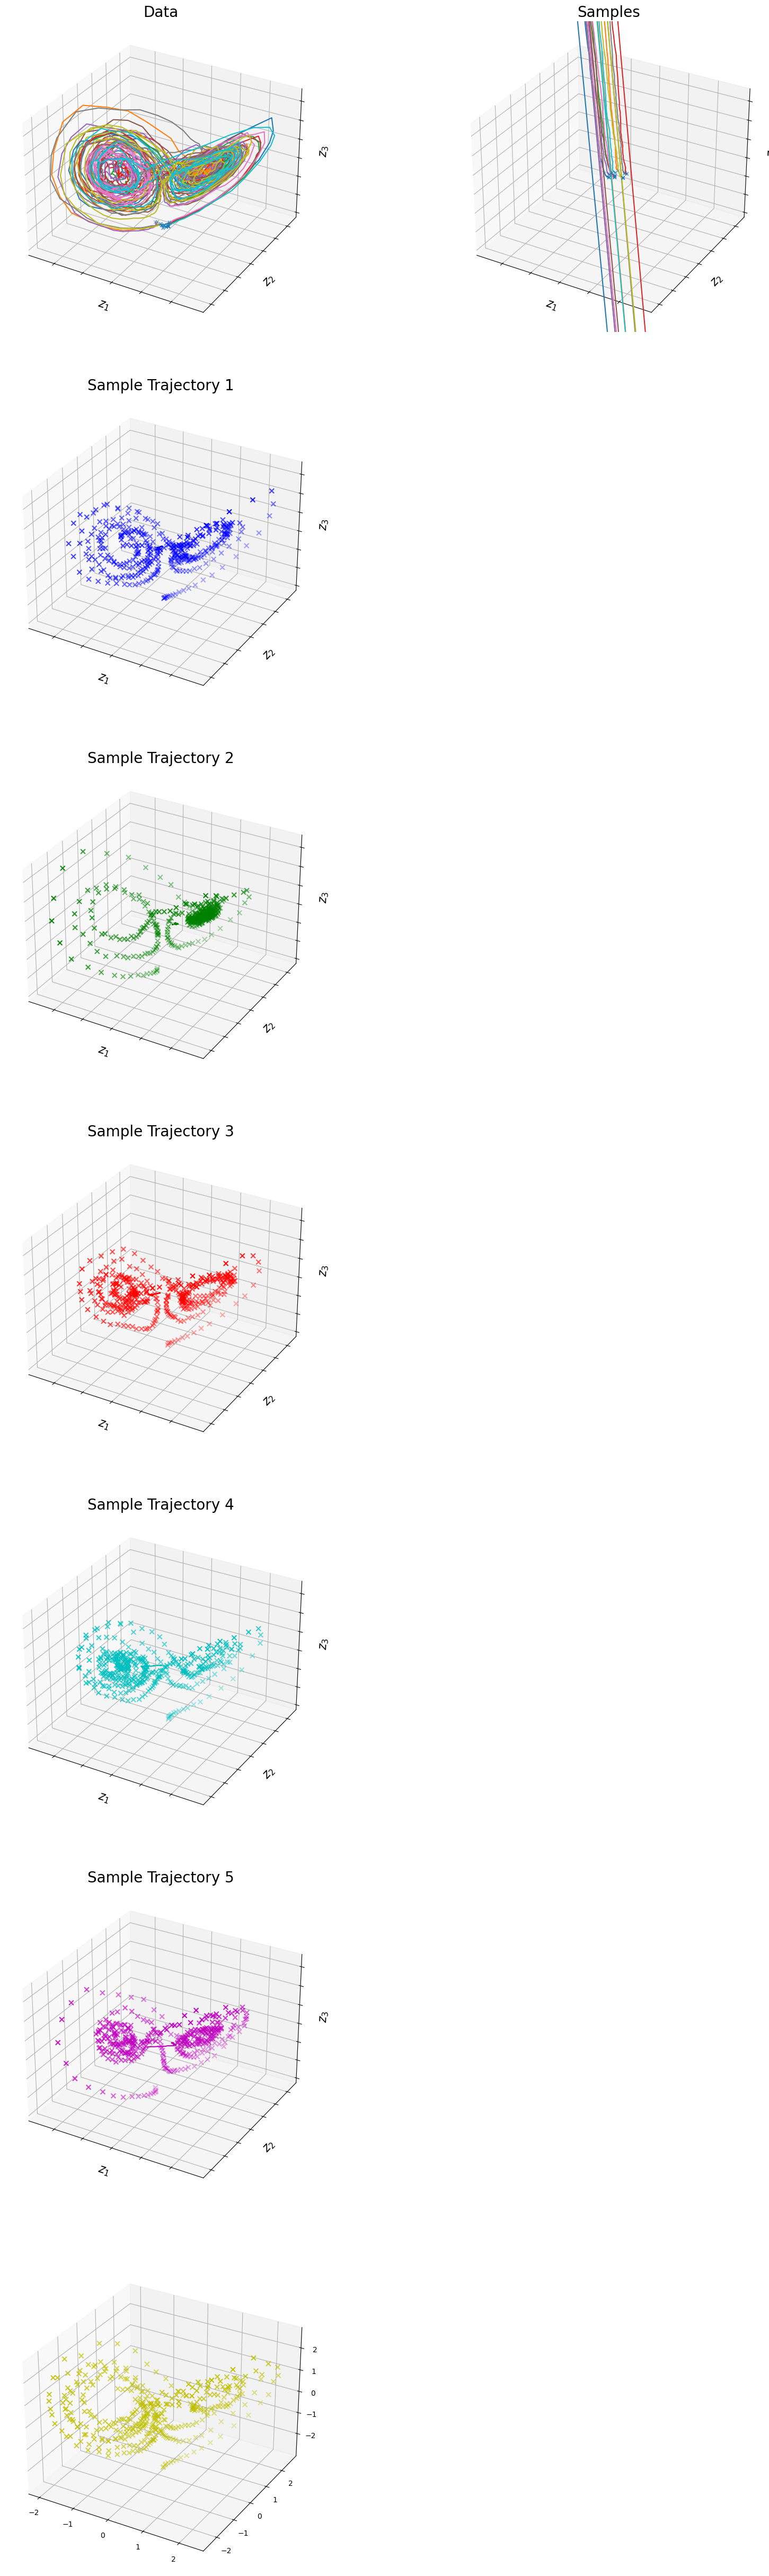

In [16]:
num_iters=5000

for global_step in tqdm.tqdm(range(1, num_iters + 1)):
    latent_sde.zero_grad()
    log_pxs, log_ratio = latent_sde(xs, ts, noise_std, adjoint, method)
    loss = -log_pxs + log_ratio * kl_scheduler.val
    loss.backward()
    optimizer.step()
    scheduler.step()
    kl_scheduler.step()

    if global_step % pause_every == 0:
        lr_now = optimizer.param_groups[0]['lr']
        logging.warning(
            f'global_step: {global_step:06d}, lr: {lr_now:.5f}, '
            f'log_pxs: {log_pxs:.4f}, log_ratio: {log_ratio:.4f} loss: {loss:.4f}, kl_coeff: {kl_scheduler.val:.4f}'
        )
        img_path = os.path.join(train_dir, f'global_step_{global_step:06d}.pdf')
        vis(xs, ts, latent_sde, bm_vis, img_path)

